RQ:
How many levels of abstractions are there in the current test suite of quantum platforms? (Qiskit)

Download the repository of Cirq and Qiskit and extract all the methods which start with "test_" in a file which contains "test".
Apply statis analysis. Inspect the average test method length and which APIs are called most often.

https://github.com/Qiskit/qiskit-terra/blob/main/test/python/circuit/test_bit.py

https://github.com/quantumlib/Cirq/blob/master/cirq-core/cirq/experiments/cross_entropy_benchmarking_test.py

In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
import os
from os.path import join

In [2]:
import ast
import astpretty
import hashlib
import json
import glob

In [3]:
DATA_PATH = "../data/static_code_analysis"

## Single file data extraction

In [28]:
test_file_path = join(DATA_PATH, "qiskit-terra/test/python/circuit/test_bit.py")
test_file_path

'../data/static_code_analysis/qiskit-terra/test/python/circuit/test_bit.py'

In [29]:
file_content = open(test_file_path, 'r').read()
   
tree = ast.parse(file_content)

astpretty.pprint(tree, show_offsets=False)
    

Module(
    body=[
        Expr(
            value=Constant(value='Test library of quantum circuits.', kind=None),
        ),
        ImportFrom(
            module='unittest',
            names=[alias(name='mock', asname=None)],
            level=0,
        ),
        ImportFrom(
            module='qiskit.test',
            names=[alias(name='QiskitTestCase', asname=None)],
            level=0,
        ),
        ImportFrom(
            module='qiskit.circuit',
            names=[
                alias(name='bit', asname=None),
                alias(name='QuantumRegister', asname=None),
            ],
            level=0,
        ),
        ClassDef(
            name='TestBitClass',
            bases=[Name(id='QiskitTestCase', ctx=Load())],
            keywords=[],
            body=[
                Expr(
                    value=Constant(value='Test library of boolean logic quantum circuits.', kind=None),
                ),
                FunctionDef(
                    name='tes

In [30]:
class MethodGetter(ast.NodeVisitor):
    
    def __init__(self, original_code):
        self.methods = []
        self.original_code = original_code

    def recursive(func):
        """ decorator to make visitor work recursive """
        def wrapper(self,node):
            func(self,node)
            for child in ast.iter_child_nodes(node):
                self.visit(child)
        return wrapper
    
    @recursive
    def visit(self, node):
        if isinstance(node, ast.FunctionDef):
            # print(node.name)
            method_name = node.name
            method_content = ast.get_source_segment(
                self.original_code, node)
            #print(f"method_name: {method_name}")
            #print("Content:")
            #print(method_content)
            self.methods.append((method_name, method_content))
        
    def get_method_names(self):
        return sorted(self.methods)

In [31]:
class APICallsCollector(ast.NodeVisitor):
    
    def __init__(self):
        self.api_calls = []    
        self.identifiers_used = []    

    def recursive(func):
        """ decorator to make visitor work recursive """
        def wrapper(self,node):
            func(self,node)
            for child in ast.iter_child_nodes(node):
                self.visit(child)
        return wrapper
    
    @recursive
    def visit(self, node):
        if isinstance(node, ast.Call):
            if isinstance(node.func, ast.Attribute):
                function_call = node.func.attr
                # print(function_call)
                self.api_calls.append(function_call)
        if isinstance(node, ast.Name):
            # print(node.id)
            self.identifiers_used.append(node.id)
    
    def get_used_classes(self):
        classes_in_identifiers = [
            identif
            for identif in self.identifiers_used
            if identif[0].isupper()
        ]
        # sometime the class name are present as constructors 
        # which means they look like function calls.
        classes_in_api_calls = [
            call
            for call in self.api_calls
            if call[0].isupper()
        ]
        all_classes = set(classes_in_identifiers + classes_in_api_calls)
        return sorted(list(all_classes))
    
    
    def get_used_function_calls(self):
        real_function_calls = [
            call
            for call in self.api_calls
            if not call[0].isupper()
        ]
        return sorted(list(set(real_function_calls)))
    
    
    def get_used_identifiers(self):
        real_identifiers = [
            identif
            for identif in self.identifiers_used
            if not identif[0].isupper()
        ]
        return sorted(list(set(real_identifiers)))
        
mth_visitor = MethodGetter(original_code=file_content)
api_visitor = APICallsCollector()

In [32]:
mth_visitor.generic_visit(tree)
api_visitor.generic_visit(tree)

In [33]:
mth_visitor.get_method_names()

[('test_bit_eq_invalid_type_comparison',
  'def test_bit_eq_invalid_type_comparison(self):\n        orig_reg = mock.MagicMock()\n        orig_reg.size = 3\n        test_bit = bit.Bit(orig_reg, 0)\n        self.assertNotEqual(test_bit, 3.14)'),
 ('test_bit_register_backreferences_deprecated',
  'def test_bit_register_backreferences_deprecated(self):\n        """Verify we raise a deprecation warning for register back-references."""\n\n        qr = QuantumRegister(3, "test_qr")\n        qubit = qr[0]\n\n        with self.assertWarnsRegex(DeprecationWarning, "deprecated"):\n            _ = qubit.index\n\n        with self.assertWarnsRegex(DeprecationWarning, "deprecated"):\n            _ = qubit.register'),
 ('test_bits_do_not_require_registers',
  'def test_bits_do_not_require_registers(self):\n        """Verify we can create a bit outside the context of a register."""\n        self.assertIsInstance(bit.Bit(), bit.Bit)'),
 ('test_newstyle_bit_equality',
  'def test_newstyle_bit_equality(s

In [34]:
api_visitor.get_used_classes()

['Bit', 'DeprecationWarning', 'MagicMock', 'QiskitTestCase', 'QuantumRegister']

In [35]:
api_visitor.get_used_function_calls()

['assertEqual', 'assertIsInstance', 'assertNotEqual', 'assertWarnsRegex']

In [36]:
api_visitor.get_used_identifiers()

['_',
 'bit',
 'bit1',
 'bit2',
 'mock',
 'orig_reg',
 'qr',
 'qubit',
 'reg_copy',
 'reg_difftype',
 'reg_larger',
 'reg_renamed',
 'self',
 'test_bit',
 'test_reg']

In [37]:
def parse_test_file(filepath):
    """Return all the method names in a file."""
    
    file_content = open(filepath, 'r').read()
    tree = ast.parse(file_content)
    mth_visitor = MethodGetter(file_content)
    api_visitor = APICallsCollector()
    mth_visitor.generic_visit(tree)
    api_visitor.generic_visit(tree)
    id_md5 = hashlib.md5(filepath.encode()).hexdigest()
    methods_w_text = [
        mth_info for mth_info in mth_visitor.get_method_names()
        if mth_info[0].startswith("test_")]
    only_methods = [m[0] for m in methods_w_text]
    new_test_records = [
        {
            "id": id_md5,
            "filepath": filepath,
            "filename": os.path.basename(filepath),
            "parent_folder": os.path.basename(os.path.dirname(filepath)),
            "other_tests": only_methods,
            "test_name": e[0],
            "test_code": e[1],
            "api_call": api_visitor.get_used_function_calls(),
            "identifiers": api_visitor.get_used_identifiers(),
            "classes": api_visitor.get_used_classes()
        }
        for e in methods_w_text
    ]
    return new_test_records

parse_test_file(filepath=test_file_path)

[{'id': 'c8da25061c95e91a4c7f4e22714916f1',
  'filepath': '../data/static_code_analysis/qiskit-terra/test/python/circuit/test_bit.py',
  'filename': 'test_bit.py',
  'parent_folder': 'circuit',
  'other_tests': ['test_bit_eq_invalid_type_comparison',
   'test_bit_register_backreferences_deprecated',
   'test_bits_do_not_require_registers',
   'test_newstyle_bit_equality',
   'test_old_style_bit_equality'],
  'test_name': 'test_bit_eq_invalid_type_comparison',
  'test_code': 'def test_bit_eq_invalid_type_comparison(self):\n        orig_reg = mock.MagicMock()\n        orig_reg.size = 3\n        test_bit = bit.Bit(orig_reg, 0)\n        self.assertNotEqual(test_bit, 3.14)',
  'api_call': ['assertEqual',
   'assertIsInstance',
   'assertNotEqual',
   'assertWarnsRegex'],
  'identifiers': ['_',
   'bit',
   'bit1',
   'bit2',
   'mock',
   'orig_reg',
   'qr',
   'qubit',
   'reg_copy',
   'reg_difftype',
   'reg_larger',
   'reg_renamed',
   'self',
   'test_bit',
   'test_reg'],
  'classes

## Scan through multiple files

In [183]:
repositories = ['qiskit-terra', 'Cirq']

testing_records = []

for repo in repositories:
    test_py_files = glob.glob(join(DATA_PATH, repo) + "/**/**.py", recursive = True)
    test_py_files =[
        name for name in test_py_files
        if os.path.basename(name).startswith("test_") or 
           os.path.basename(name).endswith("_test.py")
    ]
    for filepath in test_py_files:
        print(filepath)
        i_records = parse_test_file(filepath)
        i_records = [
            {"repository": repo, **i_record}
            for i_record in i_records
        ]
        testing_records.extend(i_records)
        
df = pd.DataFrame.from_records(testing_records)

../data/static_code_analysis/qiskit-terra/test/python/test_user_config.py
../data/static_code_analysis/qiskit-terra/test/python/test_version.py
../data/static_code_analysis/qiskit-terra/test/python/test_util.py
../data/static_code_analysis/qiskit-terra/test/python/test_examples.py
../data/static_code_analysis/qiskit-terra/test/python/test_qasm_parser.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_simulate.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_synthesis.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_utils.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_tweedledum2qiskit.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_parse.py
../data/static_code_analysis/qiskit-terra/test/python/classical_function_compiler/test_classical_function.py
../data/static_code_analysis/qiskit-

../data/static_code_analysis/qiskit-terra/test/python/algorithms/test_vqe.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/test_shor.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/test_phase_estimator.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_optimizer_nft.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_gradient_descent.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_optimizer_aqgd.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_optimizers.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_optimizers_scikitquant.py
../data/static_code_analysis/qiskit-terra/test/python/algorithms/optimizers/test_spsa.py
../data/static_code_analysis/qiskit-terra/test/python/visualization/test_utils.py
../data/static_code_analysis/qiskit-terra/test/python/visualization/test_gate_map.py


../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_hoare_opt.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_stochastic_swap.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_1q.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_remove_diagonal_gates_before_measure.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_apply_layout.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_pass_scheduler.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_instruction_durations.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_layout.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_noise_adaptive_layout.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_collect_2q_blocks.py
../data/static_code_analysis/qiskit-terra/test/python/transpiler/test_mappers.py
../data/static_code_analys

../data/static_code_analysis/qiskit-terra/test/python/opflow/test_pauli_sum_op.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_pauli_expectation.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_z2_symmetries.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_expectation_factory.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_gradients.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_state_construction.py
../data/static_code_analysis/qiskit-terra/test/python/opflow/test_cvar.py
../data/static_code_analysis/qiskit-terra/test/python/scheduler/test_basic_scheduler.py
../data/static_code_analysis/qiskit-terra/test/python/mock/test_fake_backends.py
../data/static_code_analysis/qiskit-terra/test/python/mock/test_configurable_backend.py
../data/static_code_analysis/qiskit-terra/test/python/basicaer/test_unitary_simulator.py
../data/static_code_analysis/qiskit-terra/test/python/basicaer/test_stat

../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/engine_job_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/calibration_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/simulated_local_program_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/engine_validator_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/simulated_local_engine_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/validating_sampler_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/runtime_estimator_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/abstract_local_processor_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/qcs_notebook_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/engine_sampler_test.py
../data/static_code_analysis/Cirq/cirq-google/cirq_google/engine/engine_client_test.py
../dat

../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/quil_output_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/insert_strategy_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/_bucket_priority_queue_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/qasm_output_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/text_diagram_drawer_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/optimization_pass_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/circuit_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/circuit_dag_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/circuits/frozen_circuit_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/study/resolver_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/study/sweeps_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/study/flatten_expressions_test.py
../data/static_code_analysis/Cirq/cirq-core/c

../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/google_v2_supremacy_circuit_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/xeb_sampling_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/xeb_simulation_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/grid_parallel_two_qubit_xeb_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/single_qubit_readout_calibration_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/n_qubit_tomography_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/purity_estimation_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/t2_decay_experiment_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/fidelity_estimation_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/experiments/xeb_fitting_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/contrib/json_test.py
../data/static_code_analysis/Cirq/

../data/static_code_analysis/Cirq/cirq-core/cirq/testing/gate_features_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/json_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/devices_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/consistent_specified_has_unitary_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/lin_alg_utils_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/consistent_pauli_expansion_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/consistent_phase_by_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/testing/logs_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/protocols/act_on_protocol_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/protocols/pauli_expansion_protocol_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/protocols/json_serialization_test.py
../data/static_code_analysis/Cirq/cirq-core/cirq/protocols/apply_unitary_protocol_test.py
../

## Load Data (precomputed)

In [4]:
DATASET_NAME = "backup_test_cases_info.csv"
#df.to_csv(join(DATA_PATH, DATASET_NAME), index=False)
df = pd.read_csv(join(DATA_PATH, DATASET_NAME))
df.head()

,repository,id,filepath,filename,parent_folder,other_tests,test_name,test_code,api_call,identifiers,classes
0,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_all_options_valid,def test_all_options_valid(self):\n tes...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']"
1,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_circuit_drawer_valid,def test_circuit_drawer_valid(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']"
2,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_empty_file_read,def test_empty_file_read(self):\n confi...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']"
3,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_invalid_circuit_drawer,def test_invalid_circuit_drawer(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']"
4,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_invalid_num_processes,def test_invalid_num_processes(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']"


In [22]:
df_files = df[['repository', 'id', 'filepath', 'parent_folder', 'filename', 'api_call']].drop_duplicates(subset='id')
for i, row in df_files.iterrows():
    print(f"({row['repository']}) {row['parent_folder']} > {row['filename']}")
    #for test_name in row['tests']:
        #print(f" - {test_name}")

(qiskit-terra) python > test_user_config.py
(qiskit-terra) python > test_version.py
(qiskit-terra) python > test_util.py
(qiskit-terra) python > test_examples.py
(qiskit-terra) python > test_qasm_parser.py
(qiskit-terra) classical_function_compiler > test_simulate.py
(qiskit-terra) classical_function_compiler > test_synthesis.py
(qiskit-terra) classical_function_compiler > test_utils.py
(qiskit-terra) classical_function_compiler > test_tweedledum2qiskit.py
(qiskit-terra) classical_function_compiler > test_parse.py
(qiskit-terra) classical_function_compiler > test_classical_function.py
(qiskit-terra) classical_function_compiler > test_typecheck.py
(qiskit-terra) classical_function_compiler > test_boolean_expression.py
(qiskit-terra) dagcircuit > test_dagcircuit.py
(qiskit-terra) dagcircuit > test_dagdependency.py
(qiskit-terra) dagcircuit > test_compose.py
(qiskit-terra) qobj > test_pulse_converter.py
(qiskit-terra) qobj > test_qobj.py
(qiskit-terra) qobj > test_qobj_identifiers.py
(qis

## Tokenize at Test Level

In [7]:
# example_method_code = df.iloc[0]["test_code"]
# print(example_method_code)
# my_tokens = tokenize_method(code_string=example_method_code)

In [5]:
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP, NEWLINE, INDENT, DEDENT, COMMENT, NL, ENCODING
from io import BytesIO
import re
import string

python_keywords = [
    "False", "await", "else", "import", "pass",
    "None", "break", "except", "in", "raise",
    "True", "class", "finally", "is", "return",
    "and", "continue", "for", "lambda", "try"
    "as", "def", "from", "nonlocal", "while",
    "assert", "del", "global", "not", "with",
    "async", "elif", "if", "or", "yield",
    # my additions
    "self"
]


def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

def remove_punctuation(my_string):
    return my_string.translate(str.maketrans('', '', string.punctuation))

def normalize_token(token_value):
    token_value = remove_punctuation(token_value)
    token_value = token_value.lower()
    return token_value

def tokenize_method(code_string, only_tokens=True):
    """Tokenize the method name for an NLP approach."""
    g = tokenize(BytesIO(code_string.encode('utf-8')).readline)  # tokenize the string
    tokens = []
    for token_type, token_value, _, _, _ in g:
        if token_type not in [OP, NEWLINE, INDENT, DEDENT, COMMENT, NL, ENCODING] \
                and token_value not in python_keywords:
            # convert multiline to single line because the camelcase
            # could split a mutliline in more tokens
            token_value = token_value.replace("\n",  " ")
            token_value = ' '.join(token_value.split())
            # print(token_type, token_value)            
            # we assume that a token is either CamelCase or snake_case
            # and by default we consider it CamelCase, since if it is
            # normal nothing will happen anyway
            if "_" in token_value:
                subtokens = token_value.split("_")
            else:
                subtokens = camel_case_split(token_value)
            for sub_token in subtokens:
                sub_token = normalize_token(sub_token)
                for sub_sub_token in sub_token.split():
                    tokens.append((token_type, normalize_token(sub_sub_token)))
    if not only_tokens: 
        return tokens
    return [t[1] for t in tokens]

In [6]:
df['tokens'] = df["test_code"].progress_apply(lambda code: tokenize_method(code))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9441/9441 [00:12<00:00, 746.08it/s]


## Explorative Data Analysis
Test length and most popular API

### Average test length (LoC)

In [7]:
df["n_lines"] = df["test_code"].apply(lambda code: len(code.split('\n')))

Text(100, 400, 'median testcase (LoC): 12.0')

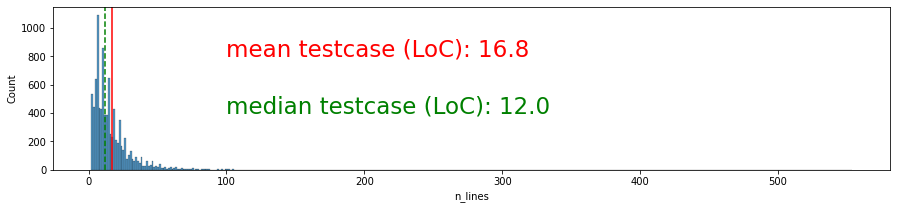

In [19]:
fig, ax = plt.subplots(figsize=(15, 3))
sns.histplot(
    data=df,
    x='n_lines'
)
mean_n_lines = df['n_lines'].mean()
median_n_lines = df['n_lines'].median()
ax.axvline(x=mean_n_lines, c='red')
ax.axvline(x=median_n_lines, c='green', linestyle='--')
ax.text(100, 800, f"mean testcase (LoC): {mean_n_lines:.1f}", fontsize=23, color='red')
ax.text(100, 400, f"median testcase (LoC): {median_n_lines:.1f}", fontsize=23, color='green')

### Most Popular API call

In [47]:
from ast import literal_eval

df_files = df[['repository', 'id', 'filepath', 'parent_folder', 'filename', 'api_call']].drop_duplicates(subset='id')
df_files['api_call'] = df_files['api_call'].apply(literal_eval) 
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752 entries, 0 to 9440
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   repository     752 non-null    object
 1   id             752 non-null    object
 2   filepath       752 non-null    object
 3   parent_folder  752 non-null    object
 4   filename       752 non-null    object
 5   api_call       752 non-null    object
dtypes: object(6)
memory usage: 41.1+ KB


We have a total of 11282 unique api calls.


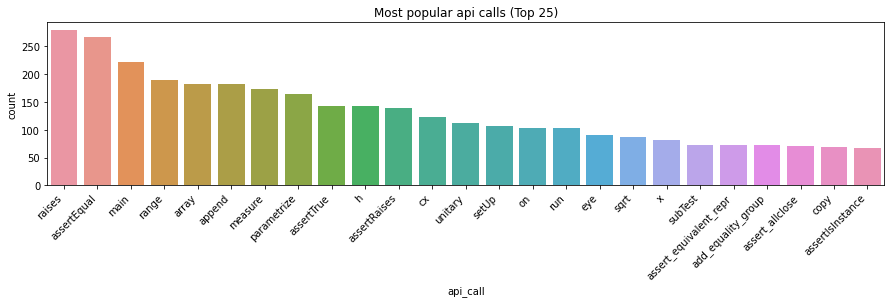

In [106]:
from collections import Counter

TOP_K = 25

all_api_calls = df_files["api_call"]
all_api_calls = [item for sublist in all_api_calls for item in sublist]
c = Counter(all_api_calls)
values, coutners = zip(*c.most_common(TOP_K))

df_counter = pd.DataFrame({'api_call': all_api_calls})
fig, ax = plt.subplots(figsize=(15, 3))
sns.countplot(
    data=df_counter,
    x='api_call',
    order=df_counter["api_call"].value_counts().iloc[:TOP_K].index,
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Most popular api calls (Top {TOP_K})")
print(f"We have a total of {len(all_api_calls)} unique api calls.")

### Which API calls are in common with the two platforms?

In [80]:
def get_all_apis(df):
    all_api_calls = df["api_call"]
    all_api_calls = [item for sublist in all_api_calls for item in sublist]
    return all_api_calls

In [90]:
df_qiskit = df_files[df_files['repository'] == 'qiskit-terra']
df_cirq = df_files[df_files['repository'] == 'Cirq']

df_counter_qiskit = pd.DataFrame({'api_call': get_all_apis(df_qiskit), "counter_qiskit": 1})
df_counter_qiskit = df_counter_qiskit.groupby(by='api_call').count()
df_counter_cirq = pd.DataFrame({'api_call': get_all_apis(df_cirq), "counter_cirq": 1})
df_counter_cirq = df_counter_cirq.groupby(by='api_call').count()

In [107]:
df_intersection = pd.merge(
    df_counter_qiskit, 
    df_counter_cirq,
    on="api_call"
)
print(f"The two libraries use or have {len(df_intersection)} api calls with the same names.")

The two libraries use or have 195 api calls with the same names.


In [104]:
TOP_K_JOINED = 35

print(f"TOP {TOP_K_JOINED} for (qiskit first, then cirq)")
df_intersection.sort_values(by=["counter_qiskit", "counter_cirq"], ascending=False).head(TOP_K_JOINED)

TOP 35 for (qiskit first, then cirq)


,counter_qiskit,counter_cirq
api_call,,
main,215,7
append,111,71
measure,82,91
run,79,25
array,70,113
rz,43,15
rx,38,22
dot,38,12
eye,37,53


In [105]:
print(f"TOP {TOP_K_JOINED} for (cirq first, then qiskit)")
df_intersection.sort_values(by=["counter_cirq", "counter_qiskit"], ascending=False).head(TOP_K_JOINED)

TOP 35 for (cirq first, then qiskit)


,counter_qiskit,counter_cirq
api_call,,
array,70,113
unitary,17,95
measure,82,91
append,111,71
assert_allclose,3,68
eye,37,53
sqrt,37,50
copy,29,40
allclose,16,37


## Compute doc representation with Spacy

In [22]:
import spacy

#spacy.prefer_gpu()
#spacy.require_gpu()

nlp = spacy.load('en_core_web_lg')

In [23]:
my_tokens = df['tokens'].iloc[0]
test_string = " ".join(my_tokens)
print(test_string)

test all options valid test config default circuit drawer latex circuit mpl style default circuit mpl style path qiskit transpile optimization level 3 suppress packaging warnings true parallel false num processes 15 add cleanup os remove file path open file path w as file file write test config file flush config user config user config file path config read config file assert equal circuit drawer latex circuit mpl style default circuit mpl style path qiskit transpile optimization level 3 num processes 15 parallel enabled config settings


In [13]:
doc = nlp(str(test_string))
doc

test all options valid test config default circuit drawer latex circuit mpl style default circuit mpl style path qiskit transpile optimization level 3 suppress packaging warnings true parallel false num processes 15 add cleanup os remove file path open file path w as file file write test config file flush config user config user config file path config read config file assert equal circuit drawer latex circuit mpl style default circuit mpl style path qiskit transpile optimization level 3 num processes 15 parallel enabled config settings

In [21]:
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
np_array.shape

In [14]:
df_subset = df[:100]

In [45]:
df["document"] = df["tokens"].progress_apply(
    lambda tokens: nlp(str(" ".join(tokens)))
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9441/9441 [12:56<00:00, 12.16it/s]


In [54]:
df_cirq = df[df['repository'] == "Cirq"]
df_qiskit = df[df['repository'] == "qiskit-terra"]

In [44]:
MAX_COMPARISONS = 30
TOP_K = 3
for i, row in df_qiskit.iterrows():
    print(f"QUERY: QISKIT: {row['test_name']}")
    #print("i: ", i)
    candidates = []
    #print(row["tokens"])
    for j, (_, to_compare) in enumerate(df_cirq.iterrows()):
        #print("j: ", j)
        if i != j:
            score = row['document'].similarity(to_compare["document"])
            candidates.append((score, j))
    ranking = sorted(candidates, reverse=True)
    for k in range(TOP_K):
        best_match = ranking[k]
        index_best_match = best_match[1]
        #print("index_best_match: ", index_best_match)
        best_match_record = df_cirq.iloc[index_best_match]
        print(f"REULST: CIRQ: {best_match_record['test_name']}")
    #print(best_match)
    print("-" * 80)
    #break
    if i > MAX_COMPARISONS:
        break

QUERY: QISKIT: test_all_options_valid


AttributeError: 'str' object has no attribute 'similarity'

In [46]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [72]:
import inspect
from subprocess import check_output
from IPython.core.display import HTML

def code_to_pprint(code):
    output = check_output(["pygmentize","-f","html","-O","full,style=emacs","-l","python"],
                input=code, encoding='ascii')
    HTML(output)
    
    
def get_top_k(index):
    """Print the top k similar document from the other library."""
    query_row = df_qiskit.iloc[index]
    
    print(f"QUERY: QISKIT: {query_row['test_name']}")
    print(query_row['test_code'])
    query_row
    #print("i: ", i)
    candidates = []
    #print(row["tokens"])
    for j, (_, to_compare) in enumerate(df_cirq.iterrows()):
        #print("j: ", j)
        if i != j:
            score = query_row['document'].similarity(to_compare["document"])
            candidates.append((score, j))
    ranking = sorted(candidates, reverse=True)
    for k in range(TOP_K):
        print(str(k), " -" * 40)
        best_match = ranking[k]
        index_best_match = best_match[1]
        #print("index_best_match: ", index_best_match)
        best_match_record = df_cirq.iloc[index_best_match]
        #print(f"RESULT: CIRQ: {best_match_record['test_name']}")
        print(best_match_record['test_code'])
    #print(best_match)
    print("-" * 80)
    

In [73]:
interact(get_top_k, index=list(zip(
    df_qiskit["test_name"], 
    list(range(len(df_qiskit["test_name"])))
)));

interactive(children=(Dropdown(description='index', options=(('test_all_options_valid', 0), ('test_circuit_dra…

In [84]:
BIG_FILE = "all_tests.py"
path_big_file = join(DATA_PATH, BIG_FILE)
with open(path_big_file, 'w') as out_file:
    for i, row in df.iterrows():
        out_file.writelines("# " + "-" * 77 + "\n")
        out_file.writelines(f'# {row["test_name"]} ({row["parent_folder"]})\n')
        out_file.writelines(f'# {row["repository"]}\n')
        out_file.writelines(f'# [{row["filepath"]}]\n')
        out_file.writelines(row["test_code"] + "\n")
    out_file.close()

In [36]:
df_cirq.head()

,repository,id,filepath,filename,parent_folder,other_tests,test_name,test_code,api_call,identifiers,classes,tokens,document
4961,Cirq,9df9b9b803fcff283515ad2f6f7ffcfd,../data/static_code_analysis/Cirq/cirq-web/cir...,widget_test.py,cirq_web,"['test_generate_html_file_with_browser', 'test...",test_generate_html_file_with_browser,def test_generate_html_file_with_browser(tmpdi...,"['__init__', '_repr_html_', 'generate_html_fil...","['actual', 'cirq_web', 'expected', 'open', 'pa...","['FakeWidget', 'Path']","[test, generate, html, file, with, browser, tm...","(test, generate, html, file, with, browser, tm..."
4962,Cirq,9df9b9b803fcff283515ad2f6f7ffcfd,../data/static_code_analysis/Cirq/cirq-web/cir...,widget_test.py,cirq_web,"['test_generate_html_file_with_browser', 'test...",test_repr_html,def test_repr_html(tmpdir):\n # # Reset the...,"['__init__', '_repr_html_', 'generate_html_fil...","['actual', 'cirq_web', 'expected', 'open', 'pa...","['FakeWidget', 'Path']","[test, repr, html, tmpdir, cirq, web, widget, ...","(test, repr, html, tmpdir, cirq, web, widget, ..."
4963,Cirq,fc42267b9d5d3130c1ff33d626d84eb6,../data/static_code_analysis/Cirq/cirq-web/cir...,_version_test.py,cirq_web,['test_version'],test_version,def test_version():\n assert cirq_web.__ver...,[],['cirq_web'],[],"[test, version, cirq, web, version, 0140dev]","(test, version, cirq, web, version, 0140dev)"
4964,Cirq,0245db2b247f4fb1ca1b4cd942e10439,../data/static_code_analysis/Cirq/cirq-web/cir...,circuit_test.py,circuits,"['test_circuit_client_code', 'test_circuit_def...",test_circuit_client_code,def test_circuit_client_code():\n qubits = ...,"['get_client_code', 'get_widget_bundle_name', ...","['circuit', 'circuit3d', 'circuit_obj', 'cirq'...","['Circuit', 'Circuit3D', 'GridQubit', 'H', 'Mo...","[test, circuit, client, code, qubits, cirq, gr...","(test, circuit, client, code, qubits, cirq, gr..."
4965,Cirq,0245db2b247f4fb1ca1b4cd942e10439,../data/static_code_analysis/Cirq/cirq-web/cir...,circuit_test.py,circuits,"['test_circuit_client_code', 'test_circuit_def...",test_circuit_default_bundle_name,def test_circuit_default_bundle_name():\n q...,"['get_client_code', 'get_widget_bundle_name', ...","['circuit', 'circuit3d', 'circuit_obj', 'cirq'...","['Circuit', 'Circuit3D', 'GridQubit', 'H', 'Mo...","[test, circuit, default, bundle, name, qubits,...","(test, circuit, default, bundle, name, qubits,..."


In [43]:
DATASET_SPACY = "backup_test_cases_info_with_spacy.csv"
#df.to_csv(join(DATA_PATH, DATASET_SPACY), index=False)
df = pd.read_csv(join(DATA_PATH, DATASET_SPACY))
df.head()

,repository,id,filepath,filename,parent_folder,other_tests,test_name,test_code,api_call,identifiers,classes,tokens,document
0,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_all_options_valid,def test_all_options_valid(self):\n tes...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']","['test', 'all', 'options', 'valid', 'test', 'c...",test all options valid test config default cir...
1,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_circuit_drawer_valid,def test_circuit_drawer_valid(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']","['test', 'circuit', 'drawer', 'valid', 'test',...",test circuit drawer valid test config default ...
2,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_empty_file_read,def test_empty_file_read(self):\n confi...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']","['test', 'empty', 'file', 'read', 'config', 'u...",test empty file read config user config user c...
3,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_invalid_circuit_drawer,def test_invalid_circuit_drawer(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']","['test', 'invalid', 'circuit', 'drawer', 'test...",test invalid circuit drawer test config defaul...
4,qiskit-terra,fc84cfe9a63c6d8594fd9cd5f883893f,../data/static_code_analysis/qiskit-terra/test...,test_user_config.py,python,"['test_all_options_valid', 'test_circuit_drawe...",test_invalid_num_processes,def test_invalid_num_processes(self):\n ...,"['addCleanup', 'assertEqual', 'assertRaises', ...","['config', 'config_settings', 'cp', 'dict', 'e...","['ConfigParser', 'QiskitTestCase', 'UserConfig']","['test', 'invalid', 'num', 'processes', 'test'...",test invalid num processes test config default...


In [174]:
df_tests['tests_w_text'].astype

<bound method NDFrame.astype of 0      (test_all_options_valid, def test_all_options_...
0      (test_circuit_drawer_valid, def test_circuit_d...
0      (test_empty_file_read, def test_empty_file_rea...
0      (test_invalid_circuit_drawer, def test_invalid...
0      (test_invalid_num_processes, def test_invalid_...
                             ...                        
755    (test_ionq_client_list_jobs_unauthorized, def ...
755    (test_ionq_client_time_travel, def test_ionq_c...
755    (test_ionq_exception_str, def test_ionq_except...
755    (test_ionq_not_found_exception_str, def test_i...
756    (test_version, def test_version():\n    assert...
Name: tests_w_text, Length: 9446, dtype: object>

In [181]:
df_tests['tests_w_text'] = df_tests['tests_w_text'].apply(list)
df_tests["x"] = df_tests['tests_w_text'].apply(lambda e: str(e[0]))
df_tests.info()

TypeError: 'float' object is not iterable

In [164]:
for i, row in df_tests.iterrows():
    print(type(row["tests_w_text"]))
    print(type(row["tests_w_text"][0]))
    break

<class 'tuple'>
<class 'str'>


In [140]:
df_sample = pd.DataFrame({'column_a': ['a_1', 'a_2'], 
                   'column_b': ['b_1', 'b_2'], 
                   'column_x': [['c_1', 'c_2'], ['d_1', 'd_2']]
                  })

In [141]:
df_sample.explode('column_x')

,column_a,column_b,column_x
0,a_1,b_1,c_1
0,a_1,b_1,c_2
1,a_2,b_2,d_1
1,a_2,b_2,d_2


## Spacy

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")
doc = nlp(u"This is a sentence.")